# Timeseries Prediction

** EVERYTHING IN THIS TUTORIAL IS VERY NEW AND EXPERIMENTAL! CONSIDER IT ON AN ALPHA PHASE!**

Topics:

* Nature of prediction models of **DynamicalSystems.jl**
* Local Model prediction
* Prediction of scalar timeseries
* Multi-variate Prediction!
* Docstrings

Suppose you have a scalar or multi-variate timeseries and you want to predict its future behaviour.

You can either take your *neural-network/machine-learning hammer* and lots of computing power **or** you can use methods from nonlinear dynamics and chaos.

**DynamicalSystems.jl** follows the second approach. This road is not only surprisingly powerful, but also much, **much** cheaper.

---

# Local Model Prediction

Local model prediction does something very simple: it makes prediction of a state, by finding the future of similar (*neighboring*) states! 

Yeap, that simple.

Let's see how good this method fares in a simple system, the Roessler system (3D & chaotic):


In [12]:
using DynamicalSystems # using TimeseriesPrediction also works
# and doesn't load ChaosTools (if you don't need it)

ds = Systems.roessler()

3-dimensional continuous dynamical system
 state:     [0.677691, 0.494734, 0.527875]
 e.o.m.:    DynamicalSystemsBase.Systems.roessler_eom
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.roessler_jacob


In [32]:
# Let's get a "measurement" from the roessler system
dt = 0.1 # sampling rate
tf = 200.0 # final time
tr = trajectory(ds, tf; dt = dt)

# This is the measurement
s = tr[25:end, 2] # we skip the first 25 points, they are transient
# This is the accompanying time vector:
timevec = collect(0:dt:tf)[25:end]
# Show s
s

1977-element Array{Float64,1}:
  0.0127737
 -0.0933719
 -0.201019 
 -0.309111 
 -0.416568 
 -0.522291 
 -0.62518  
 -0.724143 
 -0.818101 
 -0.90601  
 -0.986863 
 -1.0597   
 -1.12364  
  ⋮        
 -2.44975  
 -2.11082  
 -1.74452  
 -1.35406  
 -0.942969 
 -0.515042 
 -0.0743321
  0.374904 
  0.828246 
  1.28116  
  1.72903  
  2.16723  

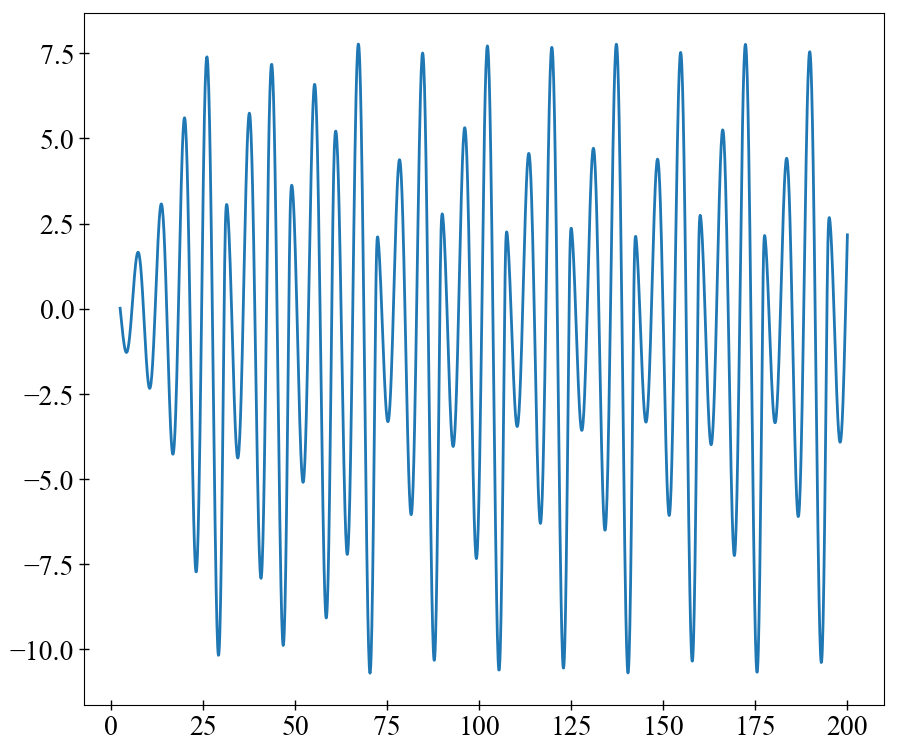

In [33]:
# How does this timeseries look?
using PyPlot
plot(timevec, s);

Please note: these are chaotic oscillations, the system is *not* periodic for the chosen (default) parameter values!

Alright, so we have a recorded measurement of length:

In [23]:
length(s)

2001

Let's see the prediction function in action! The function to use is
```julia
localmodel_tsp(s, D::Int, τ, p::Int; kwargs...)
```
Here `s` is the timeseries to be predicted. `D, τ` are the values of the `Reconstruction` that has to be made from `s`. The `Reconstruction` idea and functions where introduced in the tutorial "Delay Coordinates Embedding". The last argument `p` is simply the amount of points to predict!

This local model prediction method assumes that the system is on some kind of chaotic attractor. This is why it is crucial to reconstruct a signal before using the method!

If you already have a reconstruction of a signal, then you can just use 
```julia
localmodel_tsp(R, p::Int)
```

# Simple Scalar Prediction

First a very simple example of the Roessler system.

## Note:
Just 600 training points were needed!

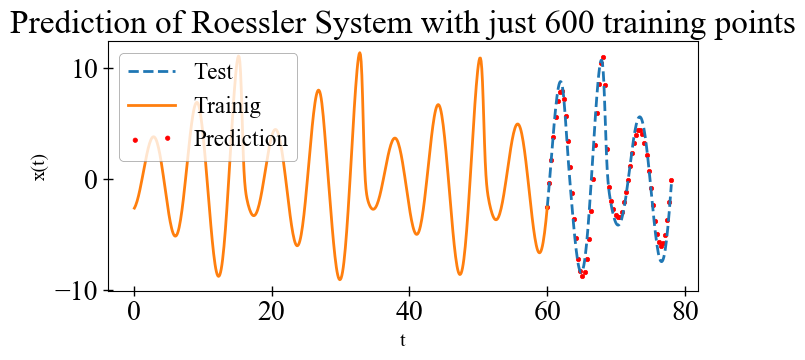

In [8]:
using DynamicalSystems, PyPlot

#Prepare timeseries
Δt = 0.1
ds = Systems.roessler()
data = trajectory(ds,500; dt=Δt);
N_skip = 500
s = data[N_skip:end,1]
stepsize = 3   #Predict only every third point


#Choose Training and Test Set
N_train = 600
p=60 
s_train = s[1:N_train]
s_test  = s[N_train:N_train+p*stepsize]


ntype = FixedMassNeighborhood(3) #Use three nearest neighbors


#Embedding Parameters
D = 3;  τ = 15



#Prediction
s_pred = localmodel_tsp(s_train,D,τ,p; ntype=ntype, stepsize=stepsize)



#Plotting
figure(figsize=(8,4))
scatter((N_train:stepsize:N_train+p*stepsize)*Δt,s_pred, s=10.,color="red",label="Prediction")
plot((N_train:N_train+p*stepsize)*Δt, s_test, "--",label="Test")
plot((1:N_train)*Δt,s_train, label="Trainig")
legend(loc="upper left")
ylabel("x(t)", size=14)
xlabel("t", size=14)
plt[:title]("Prediction of Roessler System with just $N_train training points")
tight_layout()

# Scalar Prediction

Attempt to predict the complex Lorenz96 Model.

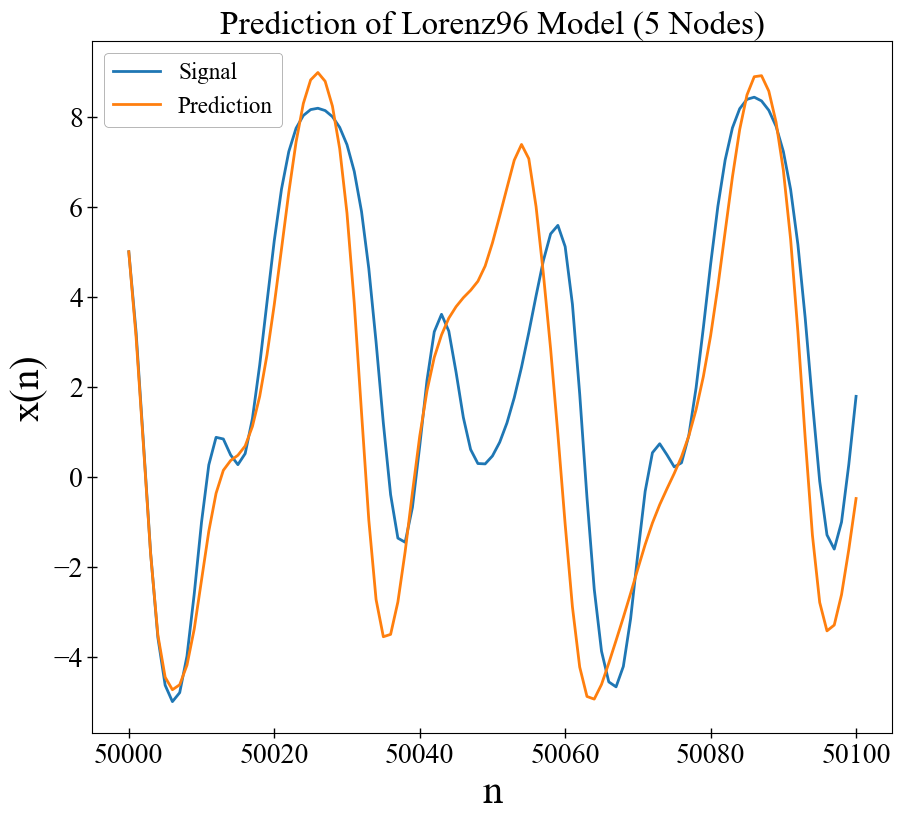

PyObject <matplotlib.text.Text object at 0x0000000000D57208>

In [5]:
using DynamicalSystemsBase, PyPlot

ds = Systems.lorenz96(5; F=8.)
Δt = 0.05
s = trajectory(ds, 2600; dt=Δt)[:,1]

N_train = 50000
p = 100
s_train = s[1:N_train]
s_test  = s[N_train:N_train+p]

D = 4; τ = 7 #Embedding Parameters
ntype = FixedMassNeighborhood(3)
s_pred  = localmodel_tsp(s_train, D, τ, p; ntype=ntype)
figure()
#plot(1:N_train, s_train)
plot(N_train:N_train+p, s_test, label="Signal")
plot(N_train:N_train+p, s_pred, label="Prediction")
ylabel("x(n)")
xlabel("n")
legend()
title("Prediction of Lorenz96 Model (5 Nodes)")

# Multi-Variate Prediction

If two components of the system are known it can be used just as well.
And the call signature did not change at all!
Still just

```julia
localmodel_tsp(s_train, D, τ, p)
```
    

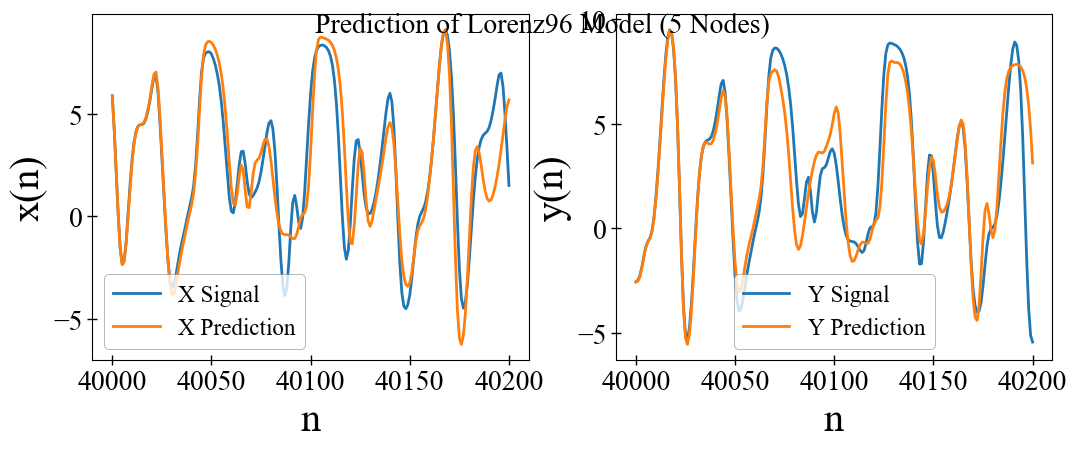

PyObject <matplotlib.text.Text object at 0x000000000144BBA8>

In [6]:
using DynamicalSystemsBase, PyPlot

#Generate timeseries set
ds = Systems.lorenz96(5; F=8.)
Δt = 0.05
s = trajectory(ds, 2100; dt=Δt)[:,1:2]

#Set Training and Test Set
N_train = 40000
p = 200
s_train = s[1:N_train,1:2]
s_test  = s[N_train:N_train+p,1:2]

#Embedding Parameters
D = 5; τ = 7

#Prediction
s_pred  = localmodel_tsp(s_train, D, τ, p)



figure(figsize=(12,4))
ax = subplot(121)
plot(N_train:N_train+p, s_test[:,1], label="X Signal")
plot(N_train:N_train+p, s_pred[:,1], label="X Prediction")
ylabel("x(n)")
xlabel("n")
legend()
ax = subplot(122)
plot(N_train:N_train+p, s_test[:,2], label="Y Signal")
plot(N_train:N_train+p, s_pred[:,2], label="Y Prediction")
ylabel("y(n)")
xlabel("n")
legend()
suptitle("Prediction of Lorenz96 Model (5 Nodes)")

# Conclusion

Predictions don't always work far into the future as errors accumulate.

The performance also depends strongly on the choice of reconstruction parameters but 
parameter estimation function of **ChaosTools.jl** can help with that.

In [10]:
?localmodel_tsp

search: localmodel_tsp AverageLocalModel AbstractLocalModel LinearLocalModel



```
localmodel_tsp(s, D::Int, τ, p::Int; method, ntype, stepsize)
localmodel_tsp(s, p::Int; method, ntype, stepsize)
```

Perform a timeseries prediction for `p` points, using local weighted modeling [1]. The function always returns an object of the same type as `s`, which can be either a timeseries (vector) or an `AbstractDataset` (trajectory), and the returned data always contains the final point of `s` as starting point. This means that the returned data has length of `p + 1`.

If given `(s, D, τ)`, then a [`Reconstruction`](@ref) is performed on `s` with dimension `D` and delay `τ`. If given only `s` then no [`Reconstruction`](@ref) is done. Keep in mind that the intented behavior of the algorithm is to work with a reconstruction, and not "raw" data.

## Keyword Arguments

  * `method = AverageLocalModel(2)` : Subtype of [`AbstractLocalModel`](@ref).
  * `ntype = FixedMassNeighborhood(2)` : Subtype of [`AbstractNeighborhood`](@ref).
  * `stepsize = 1` : Prediction step size.

## Description

Given a query point, the function finds its neighbors using neighborhood `ntype`. Then, the neighbors `xnn` and their images `ynn` are used to make a prediction for the future of the query point, using the provided `method`. The images `ynn` are the points `xnn` shifted by `stepsize` into the future.

The algorithm is applied iteratively until a prediction of length `p` has been created, starting with the query point to be the last point of the timeseries.

## References

[1] : Eds. B. Schelter *et al.*, *Handbook of Time Series Analysis*, VCH-Wiley, pp 39-65 (2006)


In [11]:
?AbstractLocalModel

search: AbstractLocalModel



```
AbstractLocalModel
```

Supertype of methods for making a prediction of a query point `q` using local models, following the methods of [1]. Concrete subtypes are `AverageLocalModel` and `LinearLocalModel`.

All models weight neighbors with the following weight function

$$
\begin{aligned}
ω_i = \left[ 1- \left(\frac{d_i}{d_{max}}\right)^n\right]^n
\end{aligned}
$$

with $d_i = ||x_{nn,i} -q||_2$ and degree `n`, to ensure smoothness of interpolation.

### Average Local Model

```
AverageLocalModel(n::Int)
```

The prediction is simply the weighted average of the images $y_{nn, i}$ of the neighbors $x_{nn, i}$ of the query point `q`:

$$
\begin{aligned}
y_{pred} = \frac{\sum{ω_i^2 y_{nn,i}}}{\sum{ω_i^2}}
\end{aligned}
$$

### Linear Local Model

```
LinearLocalModel(n::Int, μ::Real)
LinearLocalModel(n::Int, s_min::Real, s_max::Real)
```

The prediction is a weighted linear regression over the neighbors $x_{nn, i}$ of the query and their images $y_{nn,i}$ as shown in [1].

Giving either `μ` or `s_min` and `s_max` determines which type of regularization is applied.

  * `μ` : Ridge Regression

    $$
    \begin{aligned}
    f(σ) = \frac{σ^2}{μ^2 + σ^2}
    \end{aligned}
    $$
  * `s_min`, `s_max` : Soft Threshold

    $$
    \begin{aligned}
    f(σ) = \begin{cases} 0, &σ < s_{min}\\
    \left(1 - \left( \frac{s_{max}-σ}{s_{max}-s_{min}}\right)^2 \right)^2, &s_{min} \leq
    σ \leq s_{max} \\
    1, &σ > s_{max}\end{cases}
    \end{aligned}
    $$

## References

[1] : Eds. B. Schelter *et al.*, *Handbook of Time Series Analysis*, VCH-Wiley, pp 39-65 (2006)
